# Edgotyping Data Analyses

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
# from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
# from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')
# Set style
# plt.style.use('seaborn-v0_8')
sns.set_style(style='white')
sns.set_palette("husl")
%matplotlib inline

import sys
sys.path.append("../..")
from utils import *

## 1. Loading data

### 1.1 VarChAMP PPI dataset

VarChAMP PPI dataset from 1% manuscript's edgotyping scores.

In [42]:
edgotyping_scores_df = pl.read_excel("../1_inputs/VarChAMP1percentEdgotypingScores_SeqConfirmed_ONLY.xlsx")
edgotyping_scores_df.shape

(2857, 28)

#### Filtering for Pass-QC edgotyping data

Filter for alleles with good QC ONLY.

In [3]:
seq_confirm_res_df = pl.read_csv(f"../../../1_allele_collection/3_outputs/varchamp_bms_allele_collection.tsv", 
                                 separator="\t", infer_schema_length=1000000)
edgotyping_scores_df = edgotyping_scores_df.join(
    seq_confirm_res_df.filter(
        pl.col("db_seq_final")=="Y"
    ).unique("gene_variant"),
    left_on=["db_orf_id","db_mut_id"],
    right_on=["orf_id","mut_id"],
    how="inner"
)
edgotyping_scores_df.shape

(2793, 901)

### 1.2 Pillar Project CAVA PPI dataset

In [43]:
edgotyping_scores_alleles_df = pl.read_excel("../1_inputs/VarChampPillarEdgotypingScoresWithAlleleInfo_ToShare.xlsx")
edgotyping_scores_alleles_df.shape#["seq_confirmed_final"].unique()

# edgotyping_scores_alleles_df.filter(pl.col("symbol")=="RAD51D").sort("aa_change")
# edgotyping_scores_alleles_df.sort(["symbol","aa_change"])
# edgotyping_scores_alleles_df.unique(subset=["id","db_orf_id"])

(3540, 27)

#### Store the alleles from CAVA PPI dataset for allele collection

In [6]:
# edgotyping_cava_df = edgotyping_scores_alleles_df.select(
#     pl.col(["symbol","ccsb_mutation_id","ccsb_allele_id",
#             "spdi","nt_change","aa_change","category","seq_confirmed_wt_ppi",
#             "seq_confirmed_allele_ppi","seq_confirmed_final"])
# ).rename({"category": "collection"}).unique(["spdi","ccsb_mutation_id"])
# # edgotyping_cava_df.write_csv("../../../1_allele_collection/1_inputs/Edgotyping_CAVA_alleles.csv")

### 1.3 Combine two datasets

In [7]:
overlapped_cols = set(edgotyping_scores_df.columns).intersection(set(edgotyping_scores_alleles_df.columns))
combined_df = pl.concat([
    edgotyping_scores_df.select(pl.col(overlapped_cols)),
    edgotyping_scores_alleles_df.select(pl.col(overlapped_cols))
], how="vertical_relaxed").with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_variant")
)
print("Unique variants profiled:", combined_df.unique(subset="gene_variant"))
display(combined_df)

Unique variants profiled: shape: (963, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ seq_confi ┆ final_sco ┆ aa_change ┆ ccsb_alle ┆ … ┆ ad_orf_id ┆ seq_confi ┆ edgotype_ ┆ gene_var │
│ rmed_wt_p ┆ re_wt     ┆ ---       ┆ le_id     ┆   ┆ ---       ┆ rmed_fina ┆ wt_2      ┆ iant     │
│ pi        ┆ ---       ┆ str       ┆ ---       ┆   ┆ i64       ┆ l         ┆ ---       ┆ ---      │
│ ---       ┆ i64       ┆           ┆ str       ┆   ┆           ┆ ---       ┆ str       ┆ str      │
│ i64       ┆           ┆           ┆           ┆   ┆           ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1         ┆ 2         ┆ Ser393Ile ┆ ALE000046 ┆ … ┆ 100066360 ┆ 1         ┆ not       ┆ GFAP_Ser │
│           ┆           ┆           ┆ 81        ┆   ┆           ┆           ┆ perturbed ┆ 393Ile   │
│ 1         ┆ 2         ┆ Gly138Val ┆ ALE000217 

seq_confirmed_wt_ppi,final_score_wt,aa_change,ccsb_allele_id,db_orf_id,nt_change,ad_symbol,seq_confirmed_allele_ppi,symbol,ccsb_mutation_id,edgotype,final_score,spdi,ad_orf_id,seq_confirmed_final,edgotype_wt_2,gene_variant
i64,i64,str,str,i64,str,str,i64,str,str,str,str,str,i64,i64,str,str
null,3,"""Asn318Ser""","""ALE00008336""",100016069,"""953A>G""","""KCNJ15""",null,"""KCNJ2""","""CCSBVarC008350""","""perturbed""","""0""","""NC_000017.11:70175992:A:G""",6281,null,"""perturbed""","""KCNJ2_Asn318Ser"""
null,4,"""Asn318Ser""","""ALE00008336""",100016069,"""953A>G""","""KCNJ2""",null,"""KCNJ2""","""CCSBVarC008350""","""perturbed""","""0""","""NC_000017.11:70175992:A:G""",100016069,null,"""perturbed""","""KCNJ2_Asn318Ser"""
null,2,"""Glu274Asp""","""ALE00008202""",70497,"""822G>C""","""RFX6""",null,"""AGXT""","""CCSBVarC008216""","""NA""","""3""","""NC_000002.12:240875980:G:C""",2099,null,"""inconclusive""","""AGXT_Glu274Asp"""
null,1,"""Glu274Asp""","""ALE00008202""",70497,"""822G>C""","""KRT34""",null,"""AGXT""","""CCSBVarC008216""","""NA""","""2""","""NC_000002.12:240875980:G:C""",13600,null,"""NA""","""AGXT_Glu274Asp"""
null,3,"""Glu274Asp""","""ALE00008202""",70497,"""822G>C""","""CYSRT1""",null,"""AGXT""","""CCSBVarC008216""","""not perturbed""","""3""","""NC_000002.12:240875980:G:C""",13662,null,"""not perturbed""","""AGXT_Glu274Asp"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,null,"""Ser259Ala""","""ALE00013778""",732,"""775T>G""","""NRAS""",1,"""RAF1""","""CCSBVarC008858""","""NULL""","""NULL""","""NC_000003.12:12604195:A:C""",5462,1,"""NULL""","""RAF1_Ser259Ala"""
1,null,"""Leu613Val""","""ALE00011641""",732,"""1837C>G""","""NRAS""",1,"""RAF1""","""CCSBVarC008860""","""NULL""","""NULL""","""NC_000003.12:12584624:G:C""",5462,1,"""NULL""","""RAF1_Leu613Val"""
1,null,"""Gly361Ala""","""ALE00012143""",732,"""1082G>C""","""NRAS""",1,"""RAF1""","""CCSBVarC008862""","""NULL""","""NULL""","""NC_000003.12:12599717:C:G""",5462,1,"""NULL""","""RAF1_Gly361Ala"""


#### Drop the null edges

In [44]:
edgotyping_scores_final = combined_df.with_columns(
    pl.col("edgotype_wt_2").replace(["NA", "NULL"], [None, None]).alias("edgotype_wt_final")
).drop_nulls(subset="edgotype_wt_final")

print("Unique variants with edgotyping data:", edgotyping_scores_final.unique(subset="gene_variant"))

# edgotyping_scores_final.filter(
#     pl.col("gene_variant").is_in(
#         {'RAD51D_Ala231Ser',
#          'RAD51D_Cys9Ser',
#          'RAD51D_Glu307Lys',
#          'RAD51D_Gly289Ser',
#          'RAD51D_His23Arg',
#          'RAD51D_Ile251Val',
#          'RAD51D_Met308Val',
#          'RAD51D_Phe305Leu',
#          'RAD51D_Thr328Ile',
#          'RAD51D_Val132Ile',
#          'RAD51D_Val28Leu',
#          'RAD51D_Val56Gly',
#          'RAD51D_Val66Leu',
#          'RAD51D_Val66Met'}
#     )
# ).sort("gene_variant")

Unique variants with edgotyping data: shape: (832, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ seq_confi ┆ final_sco ┆ aa_change ┆ ccsb_alle ┆ … ┆ seq_confi ┆ edgotype_ ┆ gene_vari ┆ edgotype │
│ rmed_wt_p ┆ re_wt     ┆ ---       ┆ le_id     ┆   ┆ rmed_fina ┆ wt_2      ┆ ant       ┆ _wt_fina │
│ pi        ┆ ---       ┆ str       ┆ ---       ┆   ┆ l         ┆ ---       ┆ ---       ┆ l        │
│ ---       ┆ i64       ┆           ┆ str       ┆   ┆ ---       ┆ str       ┆ str       ┆ ---      │
│ i64       ┆           ┆           ┆           ┆   ┆ i64       ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1         ┆ 3         ┆ Gly73Ala  ┆ ALE000167 ┆ … ┆ 1         ┆ not       ┆ TSFM_Gly7 ┆ not pert │
│           ┆           ┆           ┆ 82        ┆   ┆           ┆ perturbed ┆ 3Ala      ┆ urbed    │
│ null      ┆ 2         ┆ Gln39Glu  

#### Summarize the allele PPI information by calculating the percentage of perturbed edges per allele

In [9]:
variant_ppi_perturb_stats = (
    edgotyping_scores_final
    .group_by("gene_variant")
    .agg([
        # Total occurrences per gene_variant
        pl.len().alias("total_occurrences"),
        # Count each edgotype category
        pl.col("edgotype_wt_final").filter(pl.col("edgotype_wt_final") == "not perturbed").len().alias("not_perturbed_count"),
        pl.col("edgotype_wt_final").filter(pl.col("edgotype_wt_final") == "inconclusive").len().alias("inconclusive_count"),
        pl.col("edgotype_wt_final").filter(pl.col("edgotype_wt_final") == "perturbed").len().alias("perturbed_count"),
    ])
    .with_columns([
        # Calculate percentages
        (pl.col("not_perturbed_count") / pl.col("total_occurrences") * 100).round(2).alias("not_perturbed_percentage"),
        (pl.col("inconclusive_count") / pl.col("total_occurrences") * 100).round(2).alias("inconclusive_percentage"),
        (pl.col("perturbed_count") / pl.col("total_occurrences") * 100).round(2).alias("perturbed_percentage")
    ]).with_columns(
        (100 - pl.col("perturbed_percentage")).alias("no_perturbed_percentage"),
        (pl.col("total_occurrences") - pl.col("perturbed_count")).alias("no_perturbed_count"),
        (pl.col("perturbed_percentage") * pl.col("total_occurrences") / 100).alias("edge_x_pt_perc")
    )
    .sort("gene_variant")
)
print(variant_ppi_perturb_stats)

shape: (832, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ gene_vari ┆ total_occ ┆ not_pertu ┆ inconclus ┆ … ┆ perturbed ┆ no_pertur ┆ no_pertur ┆ edge_x_p │
│ ant       ┆ urrences  ┆ rbed_coun ┆ ive_count ┆   ┆ _percenta ┆ bed_perce ┆ bed_count ┆ t_perc   │
│ ---       ┆ ---       ┆ t         ┆ ---       ┆   ┆ ge        ┆ ntage     ┆ ---       ┆ ---      │
│ str       ┆ u32       ┆ ---       ┆ u32       ┆   ┆ ---       ┆ ---       ┆ u32       ┆ f64      │
│           ┆           ┆ u32       ┆           ┆   ┆ f64       ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ ACSF3_Arg ┆ 3         ┆ 0         ┆ 0         ┆ … ┆ 100.0     ┆ 0.0       ┆ 0         ┆ 3.0      │
│ 10Trp     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ACSF3_Arg ┆ 3         ┆ 0         ┆ 0         ┆ … ┆ 100.0     ┆ 0.0     

## 2. ClinVar Analysis

In [10]:
variant_ppi_perturb_stats_clinvar = variant_ppi_perturb_stats.with_columns(
    pl.lit(True).alias("ppi_assayed")
).join(
    seq_confirm_res_df.select(pl.col(["gene_variant"]+[c for c in seq_confirm_res_df.columns if c not in variant_ppi_perturb_stats.columns])), 
    on=["gene_variant"],
    how="left"
).unique("gene_variant")

In [11]:
## Output the PPI scores for LLR analysis to find the optimal threshold for calling pathogenicity
# variant_ppi_perturb_stats_clinvar.filter(
#     pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"])
# ).with_columns(
#     pl.when(pl.col("clinvar_clnsig_clean")=="1_Pathogenic")
#     .then(pl.lit("Positive"))
#     .otherwise(pl.lit("Negative"))
#     .alias("referenceSet"),
#     pl.col("perturbed_percentage").alias("score"),
#     pl.col("gene_variant").alias("hgvsp")
# ).select(
#     pl.col(["hgvsp", "score", "referenceSet", "perturbed_percentage", "gene_variant", "clinvar_clnsig_clean"])
# ).write_csv("../3_outputs/PPI_referenceSet.csv")
# variant_ppi_perturb_stats_clinvar.with_columns(
#     pl.col("perturbed_percentage").alias("score"),
#     pl.col("gene_variant").alias("hgvs_pro")
# ).select(pl.col(["hgvs_pro", "score"])).write_csv("../3_outputs/PPI_allScores.csv")

In [14]:
%%bash
source ~/software/anaconda3/etc/profile.d/conda.sh
conda activate py310
Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/PPI_allScores.csv ../3_outputs/PPI_referenceSet.csv --outfile "../3_outputs/calcLLR/PPI_LLR_score_bcv" --logfile "../3_outputs/calcLLR/PPI_LLR_bcv.log" --bandwidth "bcv" --printTransitions #--outlierSuppression 0.2
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/PPI_allScores.csv ../3_outputs/PPI_referenceSet.csv --outfile "../3_outputs/calcLLR/PPI_LLR_score_nrd0" --logfile "../3_outputs/calcLLR/PPI_LLR_nrd0.log" --bandwidth "nrd0" --printTransitions #--outlierSuppression 0.1

## Non-smooth, failed bandwidth:
## No need to run any more
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_default" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_default.log" --printTransitions
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_nrd" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_nrd.log" --bandwidth "nrd" --printTransitions
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_sj" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_sj.log" --printTransitions --bandwidth "SJ"
# Rscript ../../threshold_calibration/calcLLR.R ../3_outputs/DUALIPA_allScores.csv ../3_outputs/DUALIPA_referenceSet.csv --outfile "../3_outputs/calcLLR/DUALIPA_LLR_score_nrd" --logfile "../3_outputs/calcLLR/DUALIPA_LLR_nrd.log" --bandwidth "nrd" --printTransitions

Loading required package: parallel
Loading required package: maveLLR
Warning message:
NAs introduced by coercion 


2025-08-13_01:58:17 INFO: Reading input 
2025-08-13_01:58:17 INFO: Calculating densties 


Warning messages:
1: In stats::bw.bcv(data) : minimum occurred at one end of the range
2: In stats::bw.bcv(data) : minimum occurred at one end of the range
3: In stats::bw.bcv(data) : minimum occurred at one end of the range
4: In stats::bw.bcv(data) : minimum occurred at one end of the range


2025-08-13_01:58:18 INFO: Drawing LLR plot 
2025-08-13_01:58:18 INFO: Drawing PRC curve 
  |======================================================================| 100%2025-08-13_01:58:18 INFO: Category transitions:  
63.163 : none -> patho.support
2025-08-13_01:58:18 INFO: Bootstrapping confidence intervals at  10000  iterations 
2025-08-13_01:58:18 INFO: Writing output to file  ../3_outputs/calcLLR/PPI_LLR_score_bcv.csv 
2025-08-13_01:58:18 INFO: Done! 


In [12]:
thres_manual, thres_llr = 75, 63.163
variant_ppi_perturb_stats_clinvar = variant_ppi_perturb_stats_clinvar.with_columns(
    (pl.when(pl.col("perturbed_percentage")>=thres_manual)
     .then(pl.lit(True))
     .otherwise(pl.lit(False))
    ).alias("ppi_perturbed_manual"),
    (pl.when(pl.col("perturbed_percentage")>=thres_llr)
     .then(pl.lit(True))
     .otherwise(pl.lit(False))
    ).alias("ppi_perturbed_llr"),
    pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
).with_columns(
    pl.col("clinvar_clnsig_clean").fill_null("5_Others")
)

In [14]:
# variant_ppi_perturb_stats_clinvar.write_csv("../3_outputs/edgotyping_final_combined_scores.csv")
# variant_ppi_perturb_stats_clinvar.write_csv("../../../3_integrated_assay_analyses/1_inputs/ppi/edgotyping_perturb_sum_stats.csv")

## 3. Plot Statistics

#### Percentage of perturbed edges per allele

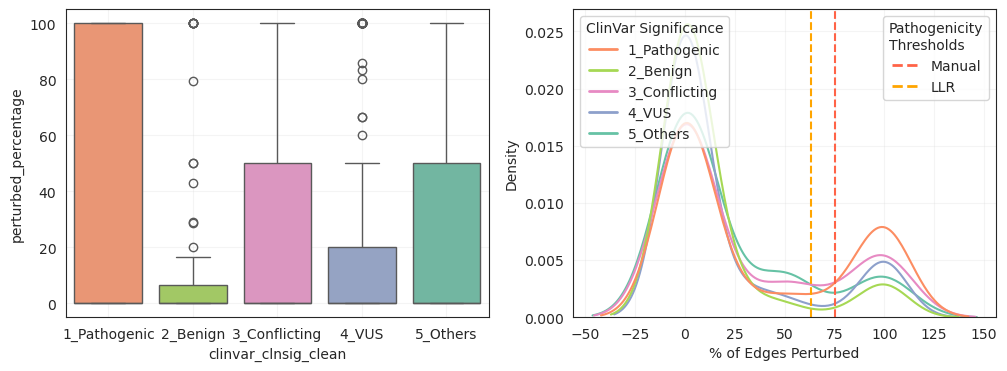

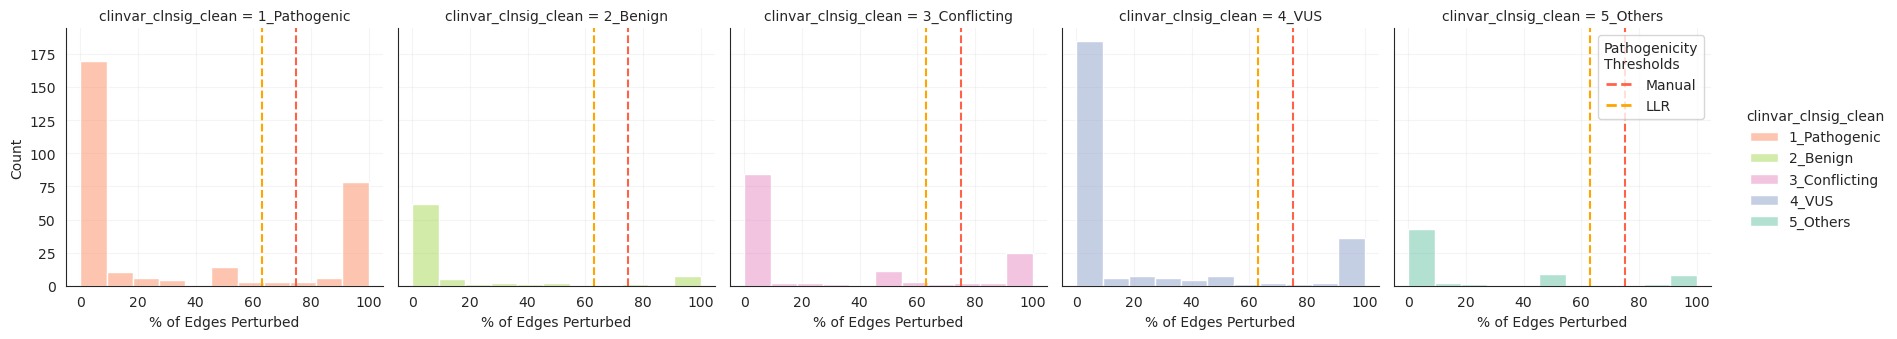

In [24]:
# edgotyping_clinvar_sum = (
#     variant_ppi_perturb_stats_clinvar
#       .group_by(["clinvar_clnsig_clean", "edgotype_wt_final"])
#       .len()
#       .sort(by="clinvar_clnsig_clean")
#       .rename({"len": "count"})
# ).with_columns(
#     pl.col("clinvar_clnsig_clean").fill_null("6_NoClinVar")
# ).to_pandas()
# # Compute the total count PER clinvar_clnsig_clean (as a Series aligned to df.index):
# totals = edgotyping_clinvar_sum.groupby("clinvar_clnsig_clean")["count"].transform("sum")
# # Now compute percentage = count ÷ total_for_that_clinvar × 100
# edgotyping_clinvar_sum["percentage"] = edgotyping_clinvar_sum["count"] / totals * 100

# Prep
hue_order = sorted(list(pd.unique(variant_ppi_perturb_stats_clinvar["clinvar_clnsig_clean"])))
# If your palette is a list, map it to labels
pal = palette_dict["clinvar_clnsig_clean"]
if not isinstance(pal, dict):
    pal = {k: c for k, c in zip(hue_order, pal)}
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.boxplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
                 palette=palette_dict["clinvar_clnsig_clean"],
                 # flier_kws=dict(facecolor=".2", linewidth=.9, marker="^"),
             ) # hue_order=["perturbed","not perturbed","inconclusive"]
ax[0].grid(alpha=.2)
# sns.violinplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
#                  palette=palette_dict["clinvar_clnsig_clean"],
#               # flier_kws=dict(facecolor=".2", linewidth=.9, marker="^"),
#              ) # hue_order=["perturbed","not perturbed","inconclusive"]
sns.kdeplot(
    data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
    x="perturbed_percentage",
    hue="clinvar_clnsig_clean",
    common_norm=False,
    hue_order=hue_order,
    ax=ax[1],
    legend=False,
    palette=pal
)
ax[1].set_xlabel("% of Edges Perturbed")
ax[1].grid(alpha=.2)

# Threshold lines
ax[1].axvline(thres_manual, color="tomato", linestyle="--")
ax[1].axvline(thres_llr,    color="orange", linestyle="--")
# ---- Build legends ----
# Legend 1: KDE curves
kde_handles = [Line2D([0], [0], color=pal[label], lw=2) for label in hue_order]
legend1 = ax[1].legend(kde_handles, hue_order, title="ClinVar Significance",
                       loc="upper left")

# Add first legend to axes
ax[1].add_artist(legend1)

# Legend 2: Threshold lines
line_handles = [
    Line2D([0], [0], color="tomato", linestyle="--", lw=2),
    Line2D([0], [0], color="orange", linestyle="--", lw=2)
]
line_labels = ["Manual", "LLR"]
ax[1].legend(line_handles, line_labels, title="Pathogenicity\nThresholds",
             loc="upper right")

g = sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="perturbed_percentage", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
                 palette=palette_dict["clinvar_clnsig_clean"], height=3.5) # hue_order=["perturbed","not perturbed","inconclusive"]
# Add grid to each subplot
for ax in g.axes.flat:
    ax.grid(True, alpha=.2)
    ax.set_xlabel("% of Edges Perturbed")
    ax.axvline(thres_manual, color="tomato", linestyle="--")
    ax.axvline(thres_llr,    color="orange", linestyle="--")
    if ax == g.axes.flat[-1]:
        line_handles = [
            Line2D([0], [0], color="tomato", linestyle="--", lw=2),
            Line2D([0], [0], color="orange", linestyle="--", lw=2)
        ]
        line_labels = ["Manual", "LLR"]
        ax.legend(line_handles, line_labels, 
                  title="Pathogenicity\nThresholds", 
                  loc="upper right")

# g = sns.catplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                 x="clinvar_clnsig_clean", y="perturbed_percentage", hue="clinvar_clnsig_clean", kind="bar", aspect=1.5, 
#                 palette="Set1", hue_order=["perturbed","not perturbed","inconclusive"])
# g = sns.catplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                 x="clinvar_clnsig_clean", y="perturbed_percentage", hue="clinvar_clnsig_clean", kind="bar", aspect=1.5, 
#                 palette="Set1", hue_order=["perturbed","not perturbed","inconclusive"])
# fig, ax = plt.subplots(1,2, figsize=(12,4.5))
# sns.swarmplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="clinvar_clnsig_clean", y="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean",
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]
# sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="perturbed_percentage", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

#### # of edges x percentage of disturbed edges

<Axes: xlabel='edge_x_pt_perc', ylabel='Density'>

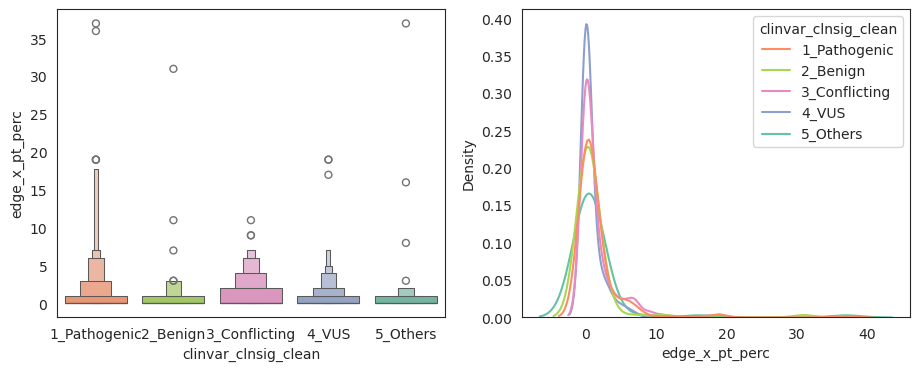

In [21]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="clinvar_clnsig_clean", y="edge_x_pt_perc", ax=ax[0],#hue="clinvar_clnsig_clean",
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]
sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
                 x="edge_x_pt_perc", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
                 palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

# sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

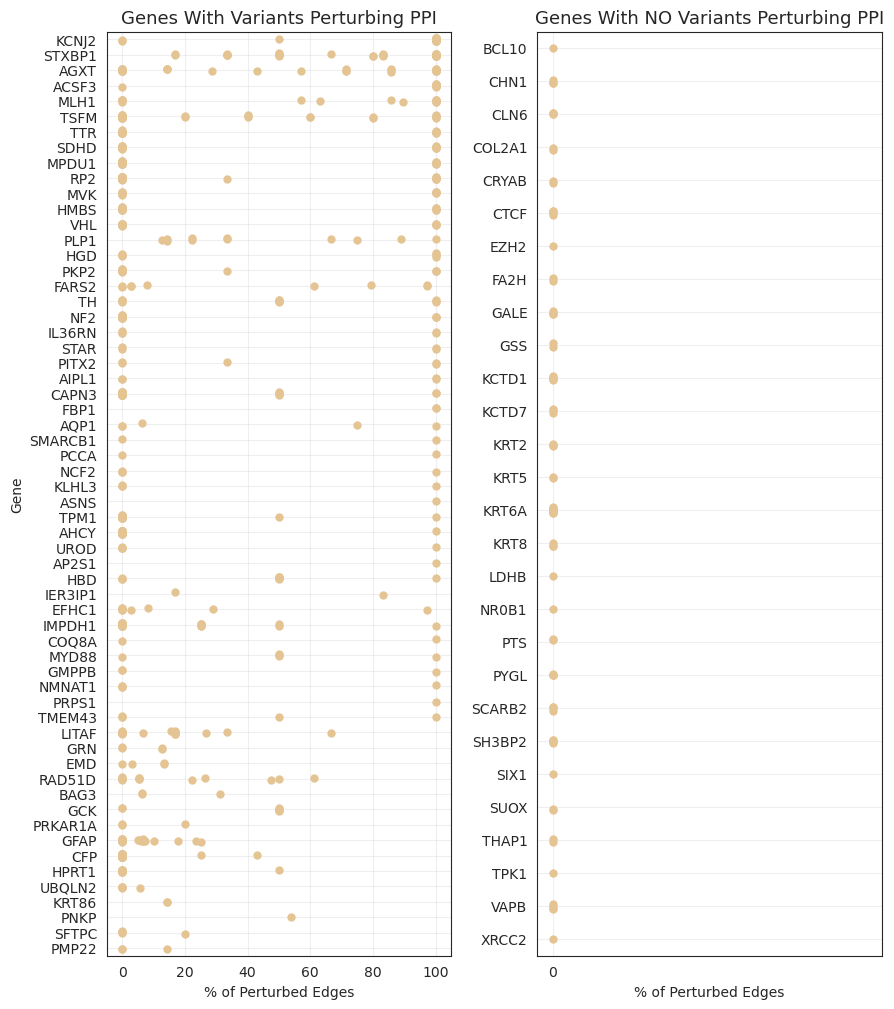

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,12))
gene_ppi_sum_df = variant_ppi_perturb_stats_clinvar.with_columns(
    (pl.col("perturbed_percentage")>thres_llr).alias("pert_perc_geq75")
).group_by(
    "symbol"
).agg(
    pl.col("pert_perc_geq75").sum().alias("pert_perc_geq75_sum"),
    pl.col("perturbed_percentage").max().alias("pert_perc_geq75_max")
)

hits_gene_order = gene_ppi_sum_df.filter(
   (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")>0)
).sort("pert_perc_geq75_sum", descending=True)['symbol']

no_hits_gene_order = gene_ppi_sum_df.filter(
   (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")==0)
).sort("symbol", descending=False)['symbol']

sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
                (pl.col("symbol").is_in(hits_gene_order)) & (pl.col("symbol").is_not_null())
              ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],
              size=6,
              y="symbol", x="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean", 
              order=hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
                (pl.col("symbol").is_in(no_hits_gene_order)) & (pl.col("symbol").is_not_null())
              ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],size=6,
              y="symbol", x="perturbed_percentage", ax=ax[1],#hue="clinvar_clnsig_clean", 
              order=no_hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
ax[0].set_ylabel("Gene")
ax[1].set_ylabel("")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax[1].set_xlabel("% of Perturbed Edges")
ax[0].set_xlabel("% of Perturbed Edges")
ax[1].set_title("Genes With NO Variants Perturbing PPI", fontsize=13)
ax[0].set_title("Genes With Variants Perturbing PPI", fontsize=13)
ax[1].set_xlim(ax[0].get_xlim())  # or just [0] if that's all you need

ax[1].set_xticks([0])  # or just [0] if that's all you need
ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)
plt.subplots_adjust(wspace=.25)

# ax.legend(loc="upper right")
# ax.axhline(75, color="tomato", linestyle="--")
# sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

# sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
#                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
#                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

In [46]:
# fig, ax = plt.subplots(1,2, figsize=(10,10))
# gene_ppi_sum_df = variant_ppi_perturb_stats_clinvar.with_columns(
#     (pl.col("perturbed_percentage")>75).alias("pert_perc_geq75")
# ).group_by(
#     "symbol"
# ).agg(
#     pl.col("pert_perc_geq75").sum().alias("pert_perc_geq75_sum"),
#     pl.col("perturbed_percentage").max().alias("pert_perc_geq75_max")
# )

# hits_gene_order = gene_ppi_sum_df.filter(
#    (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")>0)
# ).sort("pert_perc_geq75_sum", descending=True)['symbol']
# no_hits_gene_order = gene_ppi_sum_df.filter(
#    (pl.col("symbol").is_not_null()) & (pl.col("pert_perc_geq75_max")==0)
# ).sort("symbol", descending=False)['symbol']

# sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
#                 (pl.col("symbol").is_in(hits_gene_order)) & (pl.col("symbol").is_not_null())
#               ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],
#               size=6,
#               y="symbol", x="perturbed_percentage", ax=ax[0],#hue="clinvar_clnsig_clean", 
#               order=hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
# sns.stripplot(data=variant_ppi_perturb_stats_clinvar.filter(
#                 (pl.col("symbol").is_in(no_hits_gene_order)) & (pl.col("symbol").is_not_null())
#               ).to_pandas().sort_values(by="clinvar_clnsig_clean"), color=sns.color_palette("Set2")[-2],size=6,
#               y="symbol", x="perturbed_percentage", ax=ax[1],#hue="clinvar_clnsig_clean", 
#               order=no_hits_gene_order) # hue_order=["perturbed","not perturbed","inconclusive"], palette=palette_dict["clinvar_clnsig_clean"]
# ax[0].set_ylabel("Gene")
# ax[1].set_ylabel("")
# # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax[1].set_xlabel("% of Perturbed Edges")
# ax[0].set_xlabel("% of Perturbed Edges")
# ax[1].set_title("Genes With NO Variants Perturbing PPI", fontsize=13)
# ax[0].set_title("Genes With Variants Perturbing PPI", fontsize=13)
# ax[1].set_xlim(ax[0].get_xlim())  # or just [0] if that's all you need

# ax[1].set_xticks([0])  # or just [0] if that's all you need
# ax[0].grid(alpha=.3)
# ax[1].grid(alpha=.3)
# plt.subplots_adjust(wspace=.25)
# # ax.legend(loc="upper right")
# # ax.axhline(75, color="tomato", linestyle="--")

# # sns.kdeplot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
# #                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", common_norm=False, ax=ax[1], 
# #                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

# # sns.displot(data=variant_ppi_perturb_stats_clinvar.to_pandas().sort_values(by="clinvar_clnsig_clean"),
# #                  x="edge_x_pt_perc", hue="clinvar_clnsig_clean", col="clinvar_clnsig_clean", kind="hist", common_norm=False, #ax=ax, 
# #                  palette=palette_dict["clinvar_clnsig_clean"]) # hue_order=["perturbed","not perturbed","inconclusive"]

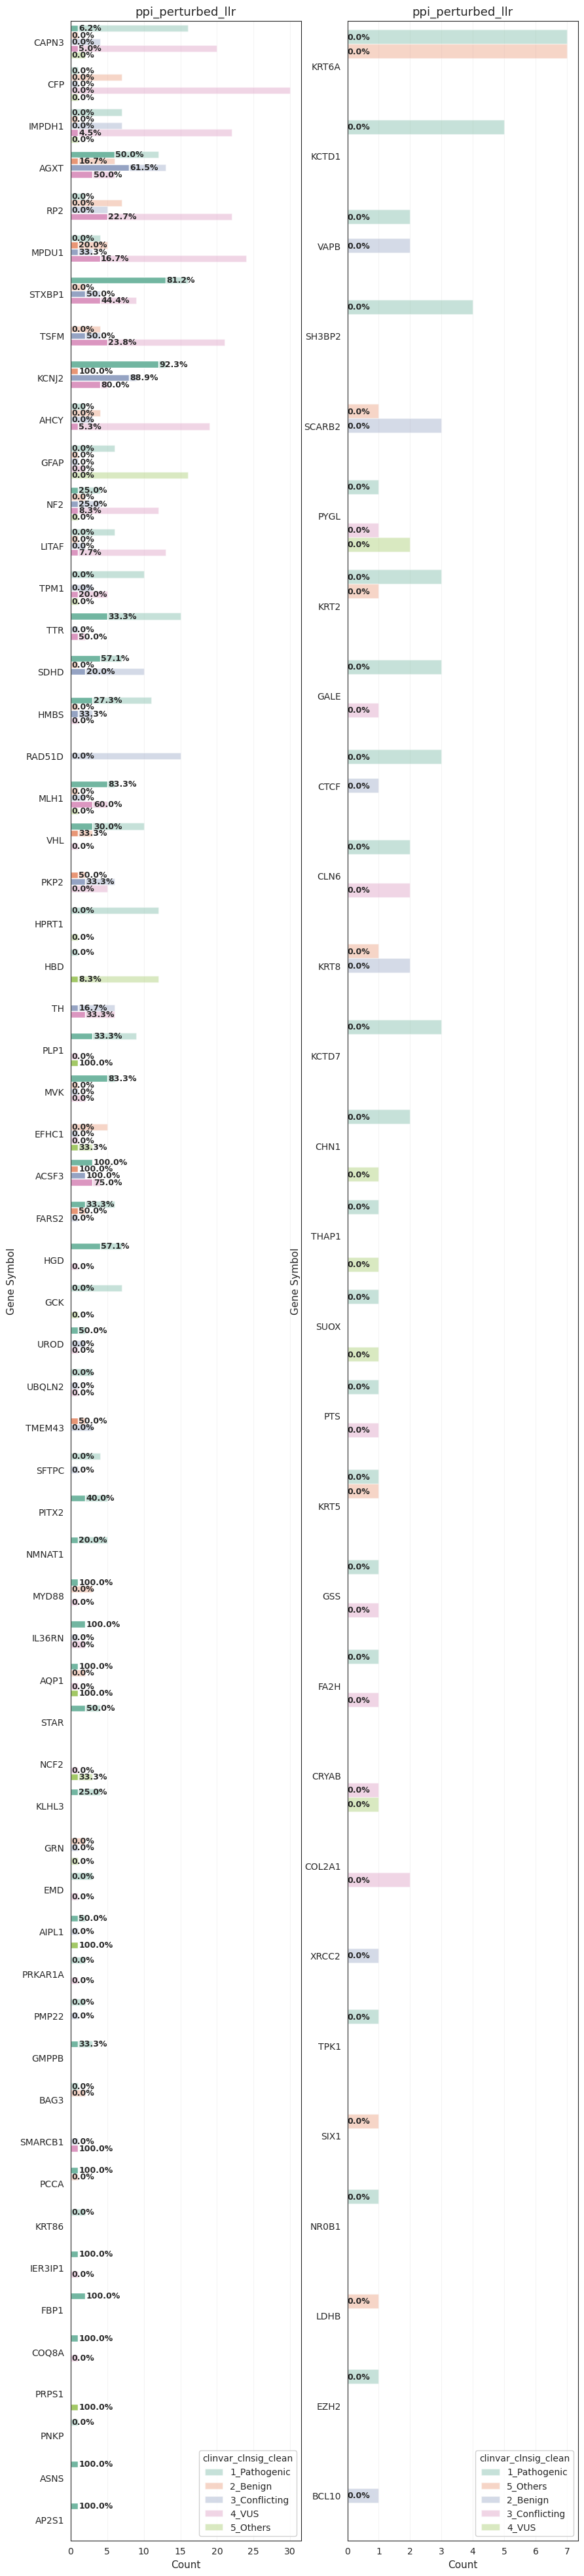

In [47]:
fig, axes = plt.subplots(1,2,figsize=(10,50))
hits_gene_sum_df = plot_gene_level_summary(variant_ppi_perturb_stats_clinvar.filter(
                            (pl.col("symbol").is_in(hits_gene_order)) & (pl.col("symbol").is_not_null())
                        ).sort(by="clinvar_clnsig_clean"),
                        assay="ppi_perturbed_llr",
                       ax=axes[0])
no_hits_gene_sum_df = plot_gene_level_summary(variant_ppi_perturb_stats_clinvar.filter(
                            (pl.col("symbol").is_in(no_hits_gene_order)) & (pl.col("symbol").is_not_null())
                        ).sort(by="clinvar_clnsig_clean"), 
                        assay="ppi_perturbed_llr",
                       ax=axes[1])

In [48]:
# variant_ppi_perturb_stats_clinvar_gene = variant_ppi_perturb_stats_clinvar.group_by("symbol","clinvar_clnsig_clean").agg(
#     pl.col("perturbed_percentage").mean().alias("perturb_perc_mean"),
#     pl.col("perturbed_percentage").median().alias("perturb_perc_median")
# )
# variant_ppi_perturb_stats_clinvar_gene

In [50]:
# plt.clf()
# hue_order = sorted(variant_ppi_perturb_stats_clinvar.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())[:2]
# benign_gene = variant_ppi_perturb_stats_clinvar.filter(pl.col("clinvar_clnsig_clean")=="2_Benign")["symbol"].unique()
# fig, ax = plt.subplots(1,1,figsize=(10, 3.5))
# sns.swarmplot(data=variant_ppi_perturb_stats_clinvar.filter(
#     pl.col("symbol").is_in(benign_gene),
#     pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]),
# ).select(
#     pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
# ).to_pandas(),
#     y="perturbed_percentage", 
#     x="symbol", 
#     hue="clinvar_clnsig_clean",
#     palette=palette_dict["clinvar_clnsig_clean"],
#     # dodge=True,
#     hue_order=hue_order,
#     # gap=.25,
#     # flier_kws=dict(facecolor=".2", linewidth=.5, marker="^"),
#     ax=ax)
# # sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.filter(
# #     pl.col("symbol").is_in(benign_gene),
# #     pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]),
# # ).select(
# #     pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
# # ).to_pandas(),
# #     y="perturbed_percentage", 
# #     x="symbol", 
# #     hue="clinvar_clnsig_clean",
# #     palette=palette_dict["clinvar_clnsig_clean"],
# #     # dodge=True,
# #     hue_order=hue_order,
# #     # gap=.25,
# #     # flier_kws=dict(facecolor=".2", linewidth=.5, marker="^"),
# #     ax=ax)
# ax.set_xlabel("Gene Symbol")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# ax.set_ylabel("Perturbed Percentage")
# ax.legend(loc="center right", frameon=True)
# ax.axhline(75, color="tomato", linestyle="--")
# ax.grid()

# # plt.clf()
# # hue_order = sorted(variant_ppi_perturb_stats_clinvar.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
# # fig, ax = plt.subplots(1,1,figsize=(10, 20))
# # sns.boxenplot(data=variant_ppi_perturb_stats_clinvar.select(
# #                 pl.col(["perturbed_percentage","symbol","clinvar_clnsig_clean"])
# #             ).to_pandas(),
# #             x="perturbed_percentage", 
# #             y="symbol", 
# #             hue="clinvar_clnsig_clean",
# #             palette=palette_dict["clinvar_clnsig_clean"],
# #             dodge=True,
# #             hue_order=hue_order,
# #             ax=ax)
# # ax.set_xlabel("perturbed_percentage")
# # ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# # ax.set_ylabel("Gene Symbol")
# # ax.grid()

<Figure size 640x480 with 0 Axes>

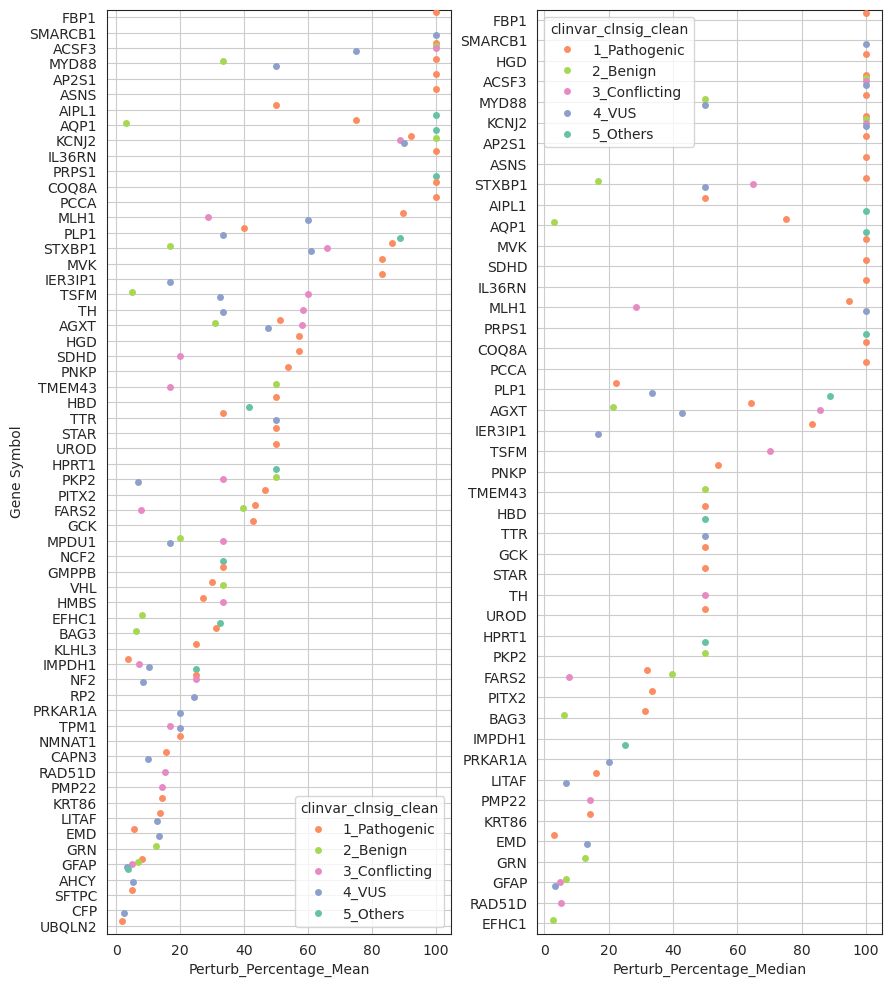

In [49]:
plt.clf()
hue_order = sorted(variant_ppi_perturb_stats_clinvar_gene.drop_nulls("clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
fig, ax = plt.subplots(1,2,figsize=(10, 12))
sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_gene.filter(pl.col("perturb_perc_mean")>0).sort("perturb_perc_mean", descending=True).select(
                pl.col(["perturb_perc_mean","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            x="perturb_perc_mean", 
            y="symbol", 
            hue="clinvar_clnsig_clean",
            palette=palette_dict["clinvar_clnsig_clean"],
            dodge=True,
            hue_order=hue_order,
            ax=ax[0])
ax[0].set_xlabel("Perturb_Percentage_Mean")
ax[0].set_ylabel("Gene Symbol")
ax[0].grid()

sns.swarmplot(data=variant_ppi_perturb_stats_clinvar_gene.filter(pl.col("perturb_perc_median")>0).sort("perturb_perc_median", descending=True).select(
                pl.col(["perturb_perc_median","symbol","clinvar_clnsig_clean"])
            ).to_pandas(),
            x="perturb_perc_median", 
            y="symbol", 
            hue="clinvar_clnsig_clean",
            dodge=True,
            palette=palette_dict["clinvar_clnsig_clean"],
            hue_order=hue_order,
            ax=ax[1])
ax[1].set_xlabel("Perturb_Percentage_Median")
ax[1].set_ylabel("")
ax[1].grid()
plt.subplots_adjust(wspace=0.25)
plt.show()

## 3. Map with Pillar Data

In [105]:
pillar_clinvar_df = pl.read_csv(
    "../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425_processed.csv", 
    infer_schema_length=1000000
)
pillar_clinvar_single_aa_df = pl.read_csv(
    "../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425_snps_only.csv",
    infer_schema_length=1000000
)

### 3.1 Exact SNP match

Text(0.5, 1.0, '54 variants overlapped\nbetween VarChAMP PPI and Pillar dataset')

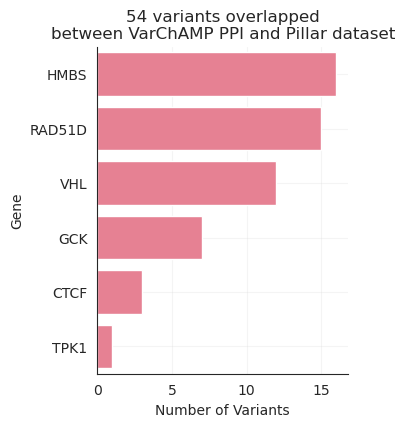

In [108]:
variant_ppi_perturb_stats_clinvar_pp_snp_overlap = variant_ppi_perturb_stats_clinvar.with_columns(
    pl.col("nuc_loc").cast(pl.Int64).alias("nuc_loc")
).join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
)
# .filter(
#     pl.col("gene_variant")==pl.col("gene_variant_pp")
# )
variant_ppi_perturb_stats_clinvar_pp_snp_overlap.unique("gene_variant").shape

g = sns.catplot(data=variant_ppi_perturb_stats_clinvar_pp_snp_overlap.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{variant_ppi_perturb_stats_clinvar_pp_snp_overlap.unique('gene_variant').shape[0]} variants overlapped\nbetween VarChAMP PPI and Pillar dataset")

In [111]:
## select key cols for output
variant_ppi_perturb_stats_clinvar_pp_snp_overlap = variant_ppi_perturb_stats_clinvar_pp_snp_overlap.select([
    col for col in variant_ppi_perturb_stats_clinvar_pp_snp_overlap.columns 
    if variant_ppi_perturb_stats_clinvar_pp_snp_overlap.select(pl.col(col).is_null().all()).item() is False
])
variant_ppi_perturb_stats_clinvar_pp_snp_overlap
variant_ppi_perturb_stats_clinvar_pp_snp_overlap.write_csv("../3_outputs/pillar_ppi_overlapped_gene_variants.csv")

In [114]:
variant_ppi_perturb_stats_clinvar_pp_snp_overlap

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Phenotype Measured ontology term,Molecular or Biological Process Investigated (GO term),IGVF_produced,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,Flag,REVEL,AM_score,AM_class,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,pillar_tested,aa_change_pp
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,bool,str
"""CTCF_Arg342Cys""",1,0,1,0,0.0,100.0,0.0,100.0,1,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010851""",null,"""NC_000016.10:67616816:C:T""","""1024C>T""","""Arg342Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,"""molecular function (GO:0003674…","""Yes""",null,null,null,null,null,null,null,null,null,null,0.559,0.9956,"""likely_pathogenic""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Arg342Cys""",true,"""Arg342Cys"""
"""CTCF_His455Gln""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010858""",null,"""NC_000016.10:67626562:C:G""","""1365C>G""","""His455Gln""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,"""molecular function (GO:0003674…","""Yes""",null,null,null,null,null,null,null,null,null,null,0.579,0.9999,"""likely_pathogenic""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_His455Gln""",true,"""His455Gln"""
"""CTCF_Tyr407Cys""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010870""",null,"""NC_000016.10:67621454:A:G""","""1220A>G""","""Tyr407Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,"""molecular function (GO:0003674…","""Yes""",null,null,null,null,null,null,null,null,null,null,0.51,0.9971,"""likely_pathogenic""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Tyr407Cys""",true,"""Tyr407Cys"""
"""GCK_Ala387Glu""",2,1,0,1,50.0,0.0,50.0,50.0,1,1.0,true,"""GCK""","""ENSG00000106633""",3689,214861,"""CCSBVarC006699""","""ALE00006697""","""NC_000007.14:44145590:G:T""","""1160C>A""","""Ala387Glu""","""CEGS2""","""CegsMutGDEh1043""","""B11""","""GDEhDisVCh_40037""","""F01""",1.0,"""CegsMutGDDh1043""","""B11""","""VUSN2Hmut_GDN2h_09""","""H03""","""VUSMutpDEST2_03""","""B10""","""VUSmut_GDEh09""","""H03""",1.0,1.0,…,"""voltage dependence of activati…","""catalytic activity (GO:0003824…","""No""","""Decreased activity""","""(-Inf, 0.66)""","""Abnormal""","""Hyperactive""","""(1.18, Inf)""","""Not specified""","""Synonymous""","""(0.66,1.18)""","""Normal"""

In [76]:
# variant_ppi_perturb_stats_clinvar_pp_snp_overlap.filter(
#     pl.col("gene_variant")!=pl.col("gene_variant_pp")
# ).unique("gene_variant")

#### Functional impact mechanistic insights

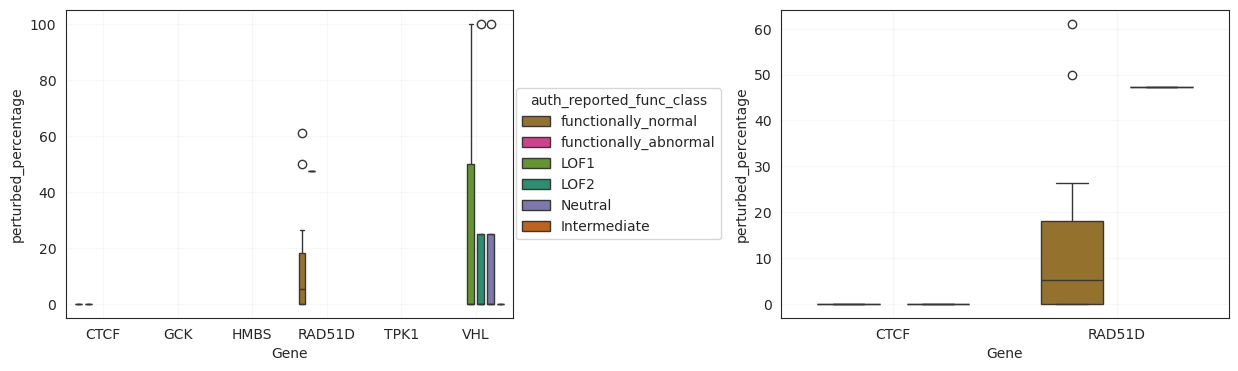

In [84]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
color_palette = dict(zip(
    variant_ppi_perturb_stats_clinvar_pp_snp_overlap["auth_reported_func_class"].sort().unique(),
    sns.color_palette("Dark2")[:len(variant_ppi_perturb_stats_clinvar_pp_snp_overlap["auth_reported_func_class"].unique())]
))
sns.boxplot(
    data=variant_ppi_perturb_stats_clinvar_pp_snp_overlap.select([
        col for col in variant_ppi_perturb_stats_clinvar_pp_snp_overlap.columns 
        if variant_ppi_perturb_stats_clinvar_pp_snp_overlap.select(pl.col(col).is_null().all()).item() is False
    ]).to_pandas(),
    x="Gene",
    y="perturbed_percentage",
    hue="auth_reported_func_class",
    palette=color_palette,
    ax=axes[0],
    legend=True,
    gap=.3
)
axes[0].legend(loc="center right", bbox_to_anchor=(1.48,0.5), title="auth_reported_func_class")

sns.boxplot(
    data=variant_ppi_perturb_stats_clinvar_pp_snp_overlap.select([
        col for col in variant_ppi_perturb_stats_clinvar_pp_snp_overlap.columns 
        if variant_ppi_perturb_stats_clinvar_pp_snp_overlap.select(pl.col(col).is_null().all()).item() is False
    ]).filter(
        pl.col("Dataset").str.contains("_unpublished")
    ).to_pandas(),
    x="Gene",
    y="perturbed_percentage",
    hue="auth_reported_func_class",
    palette=color_palette,
    ax=axes[1],
    legend=False,
    gap=.3
)
plt.subplots_adjust(wspace=.6)
for ax in axes:
    ax.grid(alpha=.15)

In [93]:
variant_ppi_perturb_stats_clinvar_pp_snp_overlap

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Classification by multifactorial model_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""CTCF_Arg342Cys""",1,0,1,0,0.0,100.0,0.0,100.0,1,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010851""",null,"""NC_000016.10:67616816:C:T""","""1024C>T""","""Arg342Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Arg342Cys""","""Arg342Cys""",true
"""CTCF_His455Gln""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010858""",null,"""NC_000016.10:67626562:C:G""","""1365C>G""","""His455Gln""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_His455Gln""","""His455Gln""",true
"""CTCF_Tyr407Cys""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010870""",null,"""NC_000016.10:67621454:A:G""","""1220A>G""","""Tyr407Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Tyr407Cys""","""Tyr407Cys""",true
"""GCK_Ala387Glu""",2,1,0,1,50.0,0.0,50.0,50.0,1,1.0,true,"""GCK""","""ENSG00000106633""",3689,214861,"""CCSBVarC006699""","""ALE00006697""","""NC_000007.14:44145590:G:T""","""1160C>A""","""Ala387Glu""","""CEGS2""","""CegsMutGDEh1043""","""B11""","""GDEhDisVCh_40037""","""F01""",1.0,"""CegsMutGDDh1043""","""B11""","""VUSN2Hmut_GDN2h_09""","""H03""","""VUSMutpDEST2_03""","""B10""","""VUSmut_GDEh09""","""H03""",1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""36181.0""","""CA213725""","""monogenic diabetes""","

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Classification by multifactorial model_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""CTCF_Arg342Cys""",1,0,1,0,0.0,100.0,0.0,100.0,1,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010851""",null,"""NC_000016.10:67616816:C:T""","""1024C>T""","""Arg342Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Arg342Cys""","""Arg342Cys""",true
"""CTCF_His455Gln""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010858""",null,"""NC_000016.10:67626562:C:G""","""1365C>G""","""His455Gln""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_His455Gln""","""His455Gln""",true
"""CTCF_Tyr407Cys""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CTCF""",null,6173,null,"""CCSBVarC010870""",null,"""NC_000016.10:67621454:A:G""","""1220A>G""","""Tyr407Cys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CTCF_Tyr407Cys""","""Tyr407Cys""",true


gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Classification by multifactorial model_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""RAD51D_Ala231Ser""",18,15,3,0,83.33,16.67,0.0,100.0,18,0.0,true,"""RAD51D""",null,7201,null,"""CCSBVarC024850""",null,"""NC_000017.11:35103301:C:A""","""691G>T""","""Ala231Ser""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_Ala231Ser""","""Ala231Ser""",true
"""RAD51D_Cys9Ser""",18,6,8,4,33.33,44.44,22.22,77.78,14,3.9996,true,"""RAD51D""",null,7201,null,"""CCSBVarC024707""",null,"""NC_000017.11:35119588:C:G""","""26G>C""","""Cys9Ser""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_Cys9Ser""","""Cys9Ser""",true
"""RAD51D_Glu307Lys""",19,10,4,5,52.63,21.05,26.32,73.68,14,5.0008,true,"""RAD51D""",null,7201,null,"""CCSBVarC024889""",null,"""NC_000017.11:35101021:C:T""","""919G>A""","""Glu307Lys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_Glu307Lys""","""Glu307Lys""",true
"""RAD51D_Gly289Ser""",19,15,4,0,78.95,21.05,0.0,100.0,19,0.0,true,"""RAD51D""",null,7201,null,"""CCSBVarC024877""",null,"""NC_000017.11:35101239:C:T""","""865G>A""","""Gly289Ser""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_Gly289Ser""","""Gly289Ser""",true
"""RAD51D_His23Arg""",19,9,9,1,47.37,47.37,5.

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Classification by multifactorial model_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,u32,u32,u32,u32,f64,f64,f64,f64,u32,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""VHL_Arg126Gly""",1,1,0,0,100.0,0.0,0.0,100.0,1,0.0,true,"""VHL""","""ENSG00000134086""",13320,204012,"""CCSBVarC006546""","""ALE00006545""","""NC_000003.12:10149822:C:G""","""376C>G""","""Arg126Gly""","""CEGS2""","""CegsMutGDEh1045""","""D09""","""GDEhDisVCh_40037""","""E05""",1.0,"""CegsMutGDDh1045""","""D09""",null,null,null,null,null,null,1.0,6.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""VHL_Arg167Gly""","""Arg167Gly""",true
"""VHL_Cys121Phe""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""VHL""","""ENSG00000134086""",13320,204015,"""CCSBVarC006548""","""ALE00006547""","""NC_000003.12:10149808:G:T""","""362G>T""","""Cys121Phe""","""CEGS2""","""CegsMutGDEh1044""","""A04""","""GDEhDisVCh_40037""","""F02""",1.0,"""CegsMutGDDh1044""","""A04""",null,null,null,null,null,null,1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""VHL_Cys162Phe""","""Cys162Phe""",true
"""VHL_Gln123Arg""",1,1,0,0,100.0,0.0,0.0,100.0,1,0.0,true,"""VHL""","""ENSG00000134086""",13320,204016,"""CCSBVarC006549""","""ALE00006548""","""NC_000003.12:10149814:A:G""","""368A>G""","""Gln123Arg""","""CEGS2""","""CegsMutGDEh1044""","""C06""","""GDEhDisVCh_40037""","""A03""",1.0,"""CegsMutGDDh1044""","""C06""",null,null,null,null,null,null,1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""VHL_Gln164Arg""","""Gln164Arg""",true
"""VHL_Glu145Lys""",1,0,1,0,0.0,100.0,0.0,100.0,1,0.0,true,"""VHL""","""ENSG00000134086""",13320,204017,"""CCSBVarC006550""","""ALE00006549""","""NC_000003.12:10149879:G:A""","""433G>A""","""Glu145Lys""","""CEGS2""","""CegsMutGDEh1044""","""G08""","""GDEh

3 [-0.73105918  0.35068748]
4 [0.73302368 0.9908464 ]


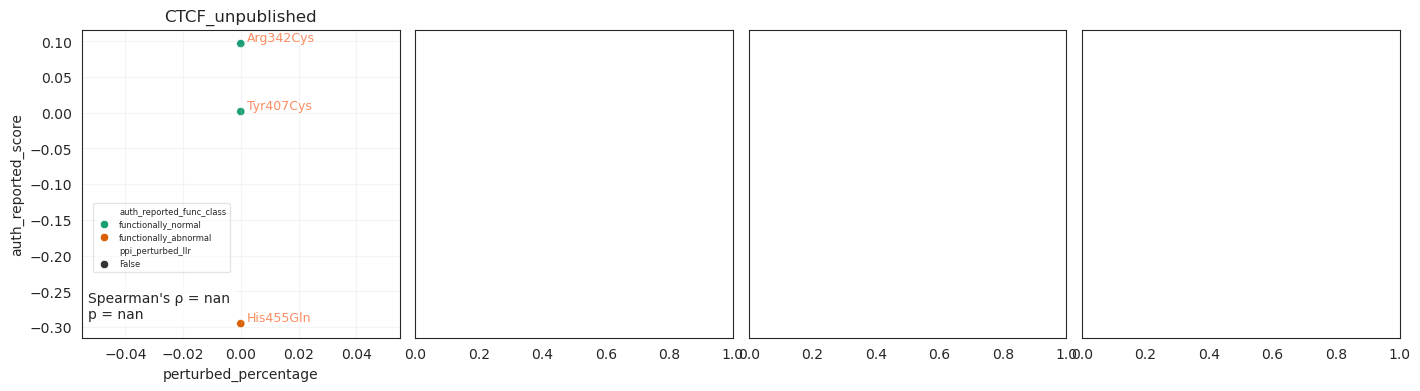

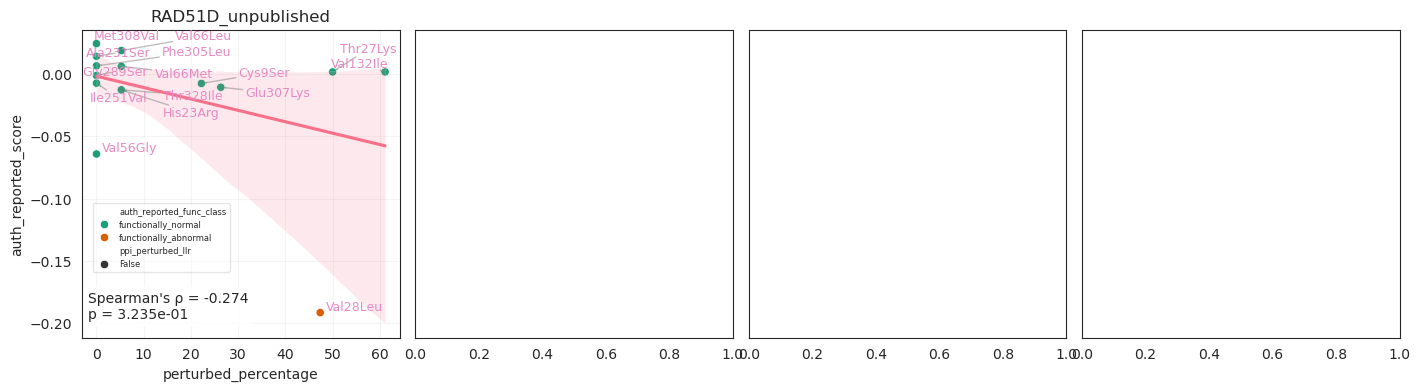

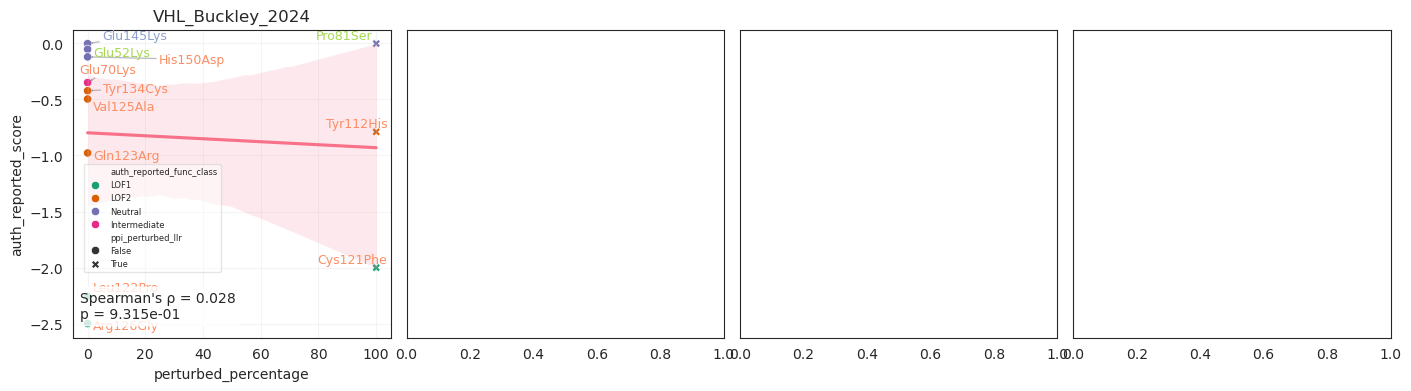

In [104]:
from scipy.stats import spearmanr
from adjustText import adjust_text

clinvar_color_map = palette_dict["clinvar_clnsig_clean"]


for gene in ["CTCF","RAD51D","VHL"]: ##,"BRCA1",
    imaging_summary_clinvar_pillar_snp_match_df_gene = variant_ppi_perturb_stats_clinvar_pp_snp_overlap.filter(
        pl.col("symbol")==gene
    )
    display(imaging_summary_clinvar_pillar_snp_match_df_gene)
    studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
    unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_variant"].unique().to_list()
    fig, axes = plt.subplots(1, 4, figsize=(17, 4), sharey=True) ##, 
    for j, study in enumerate(studies_on_gene):
       imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
           pl.col("Dataset")==study
       )
       # .select([
       #     col for col in imaging_summary_clinvar_pillar_snp_match_df_gene_study.columns 
       #     if imaging_summary_clinvar_pillar_snp_match_df_gene_study.select(pl.col(col).is_null().all()).item() is False
       # ])
       imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
           pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
       )
       for i, feat in enumerate(["perturbed_percentage"]):
           sns.scatterplot(
               data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
                   pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
                   # pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
               ).to_pandas(),
               y="auth_reported_score",
               x="perturbed_percentage",
               ax=axes[i],
               hue="auth_reported_func_class",
               style="ppi_perturbed_llr",
               palette="Dark2"
           )
           sns.regplot(
               data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
               y="auth_reported_score",
               x="perturbed_percentage",
               ax=axes[i],
               scatter=False
           )
           axes[i].legend(bbox_to_anchor=(0.02,.2), loc="lower left",
                          fontsize=6, framealpha=.5, bbox_transform=axes[i].transAxes)
           # Get pandas dataframe for easier indexing
           plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
           # Add point labels with adjustText
           texts = []
           for idx, row in plot_data.iterrows():
               if not (np.isnan(row["auth_reported_score"]) or np.isnan(row["perturbed_percentage"])):
                   clinvar_class = row["clinvar_clnsig_clean"]
                   text = axes[i].annotate(
                       row["gene_variant"].split('_')[-1],
                       (row["perturbed_percentage"], row["auth_reported_score"]),
                       fontsize=9,
                       color=clinvar_color_map[clinvar_class]
                   )
                   texts.append(text)
           adjust_text(texts, ax=axes[i], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
           # Calculate Spearman correlation
           mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"perturbed_percentage"]))
           rho, p_val = spearmanr(
               plot_data["auth_reported_score"][mask], 
               plot_data["perturbed_percentage"][mask]
           )
           # Add correlation text to plot
           axes[i].text(
               0.02, 0.15, 
               f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
               transform=axes[i].transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
           )
           if i == 0:
               axes[i].set_ylabel(f"auth_reported_score")
           else:
               axes[i].set_ylabel("")
           axes[i].set_title(study)
           axes[i].grid(alpha=.2)
    plt.subplots_adjust(wspace=0.05, hspace=0.22)